In [1]:
import numpy as np
import random as rn
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# Map
map_size = np.array([0, 10, 0, 10, 0, 10]) # min, max

# Building 0
building0 = {}
building0['Polygon'] = [(0,4), (4,4), (4,6), (0,6)]
building0['height'] = 8

# Building 1
building1 = {}
building1['Polygon'] = [(6,4), (10,4), (10,6), (6,6)]
building1['height'] = 8

building = {}
building['nb'] = 2
building['0'] = building0
building['1'] = building1

In [3]:
# Start, Goal
x0 = np.array([1, 1, 3])
xf = np.array([9, 9, 7])
tol = 0.25
trange = 5

In [4]:
# Other Settings
K = 1000 # number of verticies
dQ = 2.5 # Incremental Distance

In [5]:
def rand_conf(rnt):
    # Random
    r = rn.uniform(0, rnt*dQ)
    theta = rn.uniform(0, 2*np.pi)
    psi = rn.uniform(0, 2*np.pi)

    x = r*np.cos(psi)*np.cos(theta)
    y = r*np.cos(psi)*np.sin(theta)
    z = r*np.sin(psi)

    return np.array([x, y, z])

In [6]:
def nearest_vertex(qrand, G):
    num_node = len(G['node'])
    dist_vec = []
    for i in range(num_node):
        qcheck = G['node'][i]
        dq = qrand-qcheck
        dist_vec.append(np.sqrt((dq[0])**2+(dq[1])**2+(dq[2])**2))
    nearest = dist_vec.index(min(dist_vec))
    return G['node'][nearest]

In [7]:
def new_conf(qnear, qrand, dQ):
    # get normal direction vector
    dist = qrand - qnear
    norm = np.sqrt(dist[0]**2 + dist[1]**2 + dist[2]**2)
    direction = dist / norm
    return qnear + direction*dQ

In [8]:
def inside_map(qrand):
    if qrand[0] >= map_size[0] and qrand[0] <= map_size[1] and qrand[1] >= map_size[2] and qrand[1] <= map_size[3] and qrand[2] >= map_size[4] and qrand[2] <= map_size[5]:
        return True
    else:
        return False 

In [9]:
def outside_building(qrand, building):
    qrandxy = Point(qrand[0:2])

    check_vec = []

    for nb in range(building['nb']):
        building_polygon = Polygon(building[str(nb)]['Polygon'])
        building_height = building[str(nb)]['height']
    
        if not building_polygon.contains(qrandxy) and qrand[2] >= 0 and qrand[2] <= building_height:
            check_vec.append(1)
        else:
            check_vec.append(0)

    if np.sum(check_vec) == building['nb']:
        return True
    else:
        return False

In [10]:
# RRT
G = {}
G['node'] = []
G['node'].append(x0)
G['edge'] = []

qprev = x0

for k in range(K):
    # Sample Time
    rnt = rn.uniform(0, trange)

    next = True
    while next:
        # Sample new
        weight_vec = np.array([0.9, 0.1])
        weight = rn.uniform(0, 1)

        if weight >= 0 and weight <= weight_vec[0]:
            qrand = rand_conf(rnt)
        elif weight >= weight_vec[0] and weight <= (weight_vec[0] + weight_vec[1]):
            # To Final Point
            dq = qprev - xf
            norm = np.sqrt(dq[0]**2 + dq[1]**2 + dq[2]**2)
            direc = dq/norm*dQ*rnt
            qrand = qprev + direc
        
        if inside_map(qrand) == True:
            if outside_building(qrand, building):
                next = False
                break

    qnear = nearest_vertex(qrand, G)
    qnew = new_conf(qnear, qrand, dQ)
    G['node'].append(qnew)
    G['edge'].append((qnear, qnew))
    qprev = qnew
    
    # Check if final point reached
    dq = qnew - xf
    dist = np.sqrt(dq[0]**2+dq[1]**2+dq[2]**2)
    #print(dist)
    if dist <= tol:
        print('Destination Reached')
        break

Final
Random
Random
Random
Final
Final
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Final
Random
Final
Random
Random
Random
Final
Random
Random
Random
Random
Final
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Final
Random
Final
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Final
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Final
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Final
Random
Random
Random
Random
Random
Random
Random
Random
Random
Final
Random
Random
Random
Random
Random
Random
Random
Random
Random
Random
Rando

In [11]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

(0.0, 10.0)

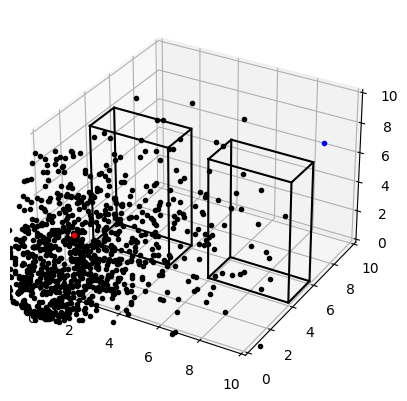

In [12]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    bz = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
            bz.append(building[str(nb)]['height'])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
            bz.append(building[str(nb)]['height'])
    ax.plot3D(bx, by, bz, '-k')
    ax.plot3D(bx, by, np.zeros(len(b)+1,), '-k')
    
    for i in range(len(b)):
        ax.plot3D([bx[i], bx[i]], [by[i], by[i]], [0, building[str(nb)]['height']], '-k')

for kk in range(len(G['node'])):
    qcurr = G['node'][kk]
    ax.plot3D(qcurr[0], qcurr[1], qcurr[2], '.k')

ax.plot3D(x0[0], x0[1], x0[2], '.r')
ax.plot3D(xf[0], xf[1], xf[2], '.b')
ax.set_xlim(map_size[0], map_size[1])
ax.set_ylim(map_size[2], map_size[3])
ax.set_zlim(map_size[4], map_size[5])